In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [ ]:
def financial_data_pipeline(
                            data_path = 'data/Operational_Data_New.xlsx',
                            answer2id = {
                                        'A1' : 0,
                                        'A2' : 1,
                                        'A3' : 2,
                                        'A4' : 3,
                                        },
                            level2id = {
                                        'L1' : 0,
                                        'L2' : 1,
                                        'L3' : 2,
                                        'L4' : 3
                                        }
                            ):
    df = pd.read_excel(
                        data_path,
                        sheet_name='Sample data'
                        )
    df['level'] = df['level'].str.split('-').str[0].str.strip()
    df = df.replace(answer2id)
    df = df.replace(level2id)

    Y = df['level'].values
    X = df.drop(columns=['level']).values

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=42)
    Xtrain = np.concatenate([Xtrain, Xtest])
    Ytrain = np.concatenate([Ytrain, Ytest])
    return Xtrain, Xtest, Ytrain, Ytest

In [24]:
Xtrain, Xtest, Ytrain, Ytest = financial_data_pipeline()

print("Xtrain.shape", Xtrain.shape)
print("Xtest.shape", Xtest.shape)
print("Ytrain.shape", Ytrain.shape)
print("Ytest.shape", Ytest.shape)

Xtrain.shape (200, 20)
Xtest.shape (40, 20)
Ytrain.shape (200,)
Ytest.shape (40,)


In [25]:
cls_01 = RandomForestClassifier(
                            n_estimators = 100, 
                            max_depth = 10
                            )

cls_02 = LGBMClassifier(
                        n_estimators = 100,
                        max_depth = 10
                        )

cls = VotingClassifier(
                    estimators = [
                        ('cls_01', cls_01),
                        ('cls_02', cls_02)
                    ]
                    )

In [26]:
cls.fit(Xtrain, Ytrain)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 20
[LightGBM] [Info] Start training from score -1.272966
[LightGBM] [Info] Start training from score -1.469676
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

VotingClassifier(estimators=[('cls_01', RandomForestClassifier(max_depth=10)),
                             ('cls_02', LGBMClassifier(max_depth=10))])

In [27]:
Ptrain = cls.predict(Xtrain)
Ptest = cls.predict(Xtest)

In [28]:
print("====================== Train CLS REPORT =======================")
clf_report = classification_report(
                                Ytrain,
                                Ptrain,
                                target_names = ['L1', 'L2', 'L3', 'L4']
                                )
print(clf_report)

print("====================== Test CLS REPORT =======================")
clf_report = classification_report(
                                Ytest, 
                                Ptest,
                                target_names = ['L1', 'L2', 'L3', 'L4']
                                )
print(clf_report)

====================== Train CLS REPORT =======================
              precision    recall  f1-score   support

          L1       1.00      1.00      1.00        56
          L2       1.00      1.00      1.00        46
          L3       1.00      1.00      1.00        48
          L4       1.00      1.00      1.00        50

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

====================== Test CLS REPORT =======================
              precision    recall  f1-score   support

          L1       1.00      1.00      1.00        11
          L2       1.00      1.00      1.00         9
          L3       1.00      1.00      1.00         9
          L4       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



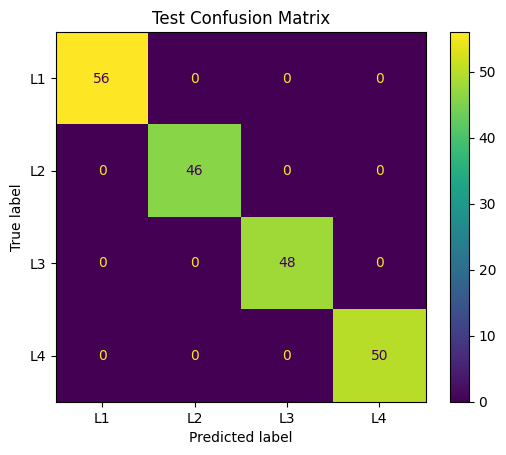

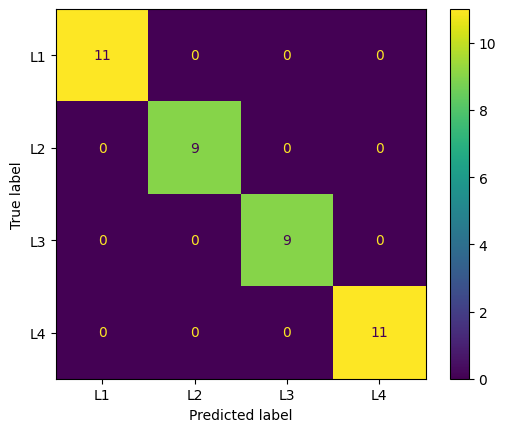

In [29]:
cm_train = confusion_matrix(Ytrain, Ptrain)
cm_test = confusion_matrix(Ytest, Ptest)

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_train,
                            display_labels = ['L1', 'L2', 'L3', 'L4']
                            )               
disp.plot()

disp = ConfusionMatrixDisplay(
                            confusion_matrix = cm_test,
                            display_labels = ['L1', 'L2', 'L3', 'L4']
                            )                  
plt.title('Test Confusion Matrix') 
disp.plot()

In [30]:
with open('artifacts/operational_cls.pkl', 'wb') as f:
    pickle.dump(cls, f)

### inference

In [32]:
with open('artifacts/operational_cls.pkl', 'rb') as f:
    cls = pickle.load(f)

In [33]:
def predict_level(
                sample_json,
                answer2id = {
                        'A1' : 0,
                        'A2' : 1,
                        'A3' : 2,
                        'A4' : 3,
                        },
                id2level = {
                        0 : 'L1',
                        1 : 'L2',
                        2 : 'L3',
                        3 : 'L4'
                        }
                ):
    
    sample_df = pd.DataFrame([sample_json])
    sample_df = sample_df.replace(answer2id)
    response = cls.predict(sample_df.values)
    level = int(response[0])
    return id2level[level]

In [ ]:
sample_json = {
            'Q1': 'A1',
            'Q2': 'A2',
            'Q3': 'A1',
            'Q4': 'A1',
            'Q5': 'A1',
            'Q6': 'A1',
            'Q7': 'A1',
            'Q8': 'A1',
            'Q9': 'A1',
            'Q10': 'A1',
            'Q11': 'A1',
            'Q12': 'A1',
            'Q13': 'A1',
            'Q14': 'A1',
            'Q15': 'A1',
            'Q16': 'A1',
            'Q17': 'A1',
            'Q18': 'A1',
            'Q19': 'A1',
            'Q20': 'A1',
            }

predict_level(sample_json)

'L1'